In [1]:
username = 'MarcelloCeresini'
repository = 'QuestionAnswering'

# COLAB ONLY CELLS
try:
    import google.colab
    IN_COLAB = True
    !pip3 install transformers
    !git clone https://www.github.com/{username}/{repository}.git
    #from google.colab import drive
    #drive.mount('/content/drive/')
    %cd /content/QuestionAnswering/src
    using_TPU = True    # If we are running this notebook on Colab, use a TPU
    # Google cloud credentials
    %env GOOGLE_APPLICATION_CREDENTIALS=/content/drive/MyDrive/Uni/Magistrale/NLP/Project/nlp-project-338723-0510aa0a4912.json
except:
    IN_COLAB = False
    using_TPU = False   # If you're not on Colab you probably won't have access to a TPU

# Configuration

## Imports

In [2]:
import os
import numpy as np
import random
from tqdm import tqdm
from functools import partial
tqdm = partial(tqdm, position=0, leave=True)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import Sequence
from typing import List, Union, Dict, Tuple
from transformers import BertTokenizerFast, DistilBertTokenizerFast, \
                         TFBertModel, TFDistilBertModel
from sklearn.feature_extraction.text import TfidfVectorizer
import utils
import json

from utils import top_n_for_question_neural, get_questions_and_paragraphs,\
    get_paragraph_from_question, decode_dataset_fn

RANDOM_SEED = 42
MAX_SEQ_LEN = 512
BERT_DIMENSIONALITY = 768

np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

### TPU check
The training could be made faster if we use the cloud GPUs offered by Google on Google Colab. Since TPUs require manual intialization and other oddities, we check multiple times throughout the notebook what kind of hardware we are running the code on.

In [3]:
if using_TPU:
    try: 
        resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
        tf.config.experimental_connect_to_cluster(resolver)
        # This is the TPU initialization code that has to be at the beginning.
        tf.tpu.experimental.initialize_tpu_system(resolver)
        print("All devices: ", tf.config.list_logical_devices('TPU'))
        strategy = tf.distribute.TPUStrategy(resolver)
    except:
        print("TPUs are not available, setting flag 'using_TPU' to False.")
        using_TPU = False
        print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
else:
    print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Paths

In [4]:
ROOT_PATH = os.path.dirname(os.getcwd())
TRAINING_FILE = os.path.join(ROOT_PATH, 'data', 'training_set.json')
VALIDATION_FILE = os.path.join(ROOT_PATH, 'data', 'validation_set.json')
TEST_FILE = os.path.join(ROOT_PATH, 'data', 'dev_set.json')

In [5]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive/')
    checkpoint_dir = '/content/drive/MyDrive/Uni/Magistrale/NLP/Project/weights/training_dpr/'
    datasets_dir = '/content/drive/MyDrive/Uni/Magistrale/NLP/Project/datasets/dpr/'
    BATCH_SIZE = 64
else:
    # Create the folder where we'll save the weights of the model
    checkpoint_dir = os.path.join("checkpoints", "training_dpr")
    datasets_dir = os.path.join(ROOT_PATH, "data", "training_dpr", "dataset")
    BATCH_SIZE = 8

os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(datasets_dir, exist_ok=True)

# Questions and paragraphs

In [6]:
train_paragraphs_and_questions = utils.read_question_set(TRAINING_FILE)['data']
val_paragraphs_and_questions = utils.read_question_set(VALIDATION_FILE)['data']
test_paragraphs_and_questions = utils.read_question_set(TEST_FILE)['data']

# Remove the validation set from the train set
train_paragraphs_and_questions = [article for article in train_paragraphs_and_questions \
                                  if article not in val_paragraphs_and_questions]

train_questions, train_paragraphs = get_questions_and_paragraphs(train_paragraphs_and_questions)
val_questions, val_paragraphs = get_questions_and_paragraphs(val_paragraphs_and_questions)
test_questions, test_paragraphs = get_questions_and_paragraphs(test_paragraphs_and_questions)

# Tokenizer

In [7]:
tokenizer_distilbert = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

We also create the Tf-Idf vectorizers for the training and test sets.

In [8]:
train_vectorizer = TfidfVectorizer(strip_accents='unicode', lowercase=True, max_df=0.8, norm='l2')
val_vectorizer = TfidfVectorizer(strip_accents='unicode', lowercase=True, max_df=0.8, norm='l2')
test_vectorizer = TfidfVectorizer(strip_accents='unicode', lowercase=True, max_df=0.8, norm='l2')

Transform all paragraphs into a vectorized representation.

In [9]:
train_docs_vect = train_vectorizer.fit_transform([train_paragraphs[i]['context'] for i in range(len(train_paragraphs))])
val_docs_vect = val_vectorizer.fit_transform([val_paragraphs[i]['context'] for i in range(len(val_paragraphs))])

test_vectorizer.fit([train_paragraphs[i]['context'] for i in range(len(train_paragraphs))] +
                    [val_paragraphs[i]['context'] for i in range(len(val_paragraphs))])
test_docs_vect = test_vectorizer.transform([test_paragraphs[i]['context'] for i in range(len(test_paragraphs))])

# Dataset creation

In [10]:
def create_dataset_from_records(questions, paragraphs, dataset, tokenizer, 
                                fn, vectorizer, docs_vect, batch_size=BATCH_SIZE):
    # Prepare strings
    filename = f'{fn}_{BERT_DIMENSIONALITY}.proto'
    fn_type = filename.split(os.sep)[-1].replace('.proto','')
    dst_name = fn_type + '.proto'
    bucket_name = 'volpepe-nlp-project-squad-datasets'
    gcs_filename = f'gs://{bucket_name}/{dst_name}'
    print(f"Loading {fn_type} dataset from GCS ({gcs_filename}).")
    # Return it as processed dataset
    dataset = tf.data.TFRecordDataset([gcs_filename]).map(decode_dataset_fn)
    dataset = dataset.apply(tf.data.experimental.assert_cardinality(len(questions)))
    dataset = dataset.shuffle(5000, reshuffle_each_iteration=True)
    dataset = dataset.batch(batch_size)
    dataset = dataset.cache()
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

### CREATE DATASETS ###
# Valid for both TPU and GPU
dataset_train = create_dataset_from_records(train_questions, train_paragraphs, train_paragraphs_and_questions, 
                                            tokenizer_distilbert, os.path.join(datasets_dir, 'train'),
                                            train_vectorizer, train_docs_vect)
dataset_val   = create_dataset_from_records(val_questions, val_paragraphs, val_paragraphs_and_questions, 
                                            tokenizer_distilbert, os.path.join(datasets_dir, 'val'),
                                            val_vectorizer, val_docs_vect)

Loading train_768 dataset from GCS (gs://volpepe-nlp-project-squad-datasets/train_768.proto).
Loading val_768 dataset from GCS (gs://volpepe-nlp-project-squad-datasets/val_768.proto).


# Model creation

In [ ]:
from utils import ReducedDistilBertModel, DenseEncoder, DeepQPEncoder

def create_model(sample, freeze_layers_up_to=5):
    print("Creating BERT models...")
    model_q, model_p =  TFDistilBertModel.from_pretrained('distilbert-base-uncased'), \
                        TFDistilBertModel.from_pretrained('distilbert-base-uncased')

    # Freeze layers 
    for i in range(freeze_layers_up_to): # layers 0 to variable are frozen, successive layers learn
        model_q.distilbert.transformer.layer[i].trainable = False
        model_p.distilbert.transformer.layer[i].trainable = False

    model_q, model_p = ReducedDistilBertModel(model_q), ReducedDistilBertModel(model_p)

    print("Creating Deep Encoder...")
    model = DeepQPEncoder(model_q, model_p)

    print("Compiling...")
    # Compile the model and loss
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=3e-6),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy()]
    )

    print("Testing on some data...")
    # Pass one batch of data to build the model
    model(sample)

    # Return the model
    print("Model created!")
    return model

In [ ]:
import datetime

# GPUs and local systems don't need the above specifications. We simply
# create a pattern for the filename and let the callbacks deal with it.
model_name = f'dpr_{BERT_DIMENSIONALITY}_hard_2nd_training'
checkpoint_path = os.path.join(checkpoint_dir, model_name + '_epoch_{epoch:03d}.ckpt')
# Workaraound for saving locally when using cloud TPUs
local_device_option = tf.train.CheckpointOptions(
    experimental_io_device="/job:localhost")

if using_TPU:
    # TPU requires to create the model within the scope of the distributed strategy
    # we're using.
    with strategy.scope():
        model = create_model(sample=next(dataset_train.take(1).as_numpy_iterator()),
                             freeze_layers_up_to=3)
else:
    # On TPU we cannot use tensorboard, but on GPU we can
    log_dir = os.path.join(ROOT_PATH, "data", "logs", 
        f"training_dpr_{BERT_DIMENSIONALITY}_hard", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    
    model = create_model(sample=next(dataset_train.take(1).as_numpy_iterator()),
                             freeze_layers_up_to=3)

In [15]:
DO_TRAINING = False

if DO_TRAINING:
    if not using_TPU:
        # Tensorboard callback is not available on TPU
        tensorboard_callback = tf.keras.callbacks.TensorBoard(
            log_dir=log_dir,
            histogram_freq=1
        )
    
    # ModelCheckpoint callback is available both on TPU and GPU 
    # with the options parameter
    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath = checkpoint_path,
        verbose = 1,
        save_weights_only = True,
        save_best_only = False,     # Save all epochs!
        options=local_device_option
    )

    # Early stopping can be used by both hardware
    es_callback = tf.keras.callbacks.EarlyStopping(
        patience = 5,
        restore_best_weights=True
    )

    callbacks = [es_callback, cp_callback]
    if not using_TPU:
        # These callback imply saving stuff on local disk, which cannot be 
        # done automatically using TPUs.
        # Therefore, they are only active when using GPUs and local systems
        callbacks.extend([tensorboard_callback])

    # We fit the model
    history = model.fit(
        dataset_train, 
        y=None,
        validation_data=dataset_val,
        epochs=100, 
        callbacks=callbacks,
        use_multiprocessing=True,
        initial_epoch=0,
        verbose=1 # Show progress bar
    )

The following is the log during training where we saved all epochs' weights as checkpoints.

Epoch 1/200

loss: 1.2540 - sparse_categorical_accuracy: 0.5642 - val_loss: 0.8112 - val_sparse_categorical_accuracy: 0.5853

---

Epoch 2/200

loss: 0.7349 - sparse_categorical_accuracy: 0.6197 - val_loss: 0.7368 - val_sparse_categorical_accuracy: 0.6097

---

Epoch 3/200


loss: 0.6743 - sparse_categorical_accuracy: 0.6381 - val_loss: 0.7040 - val_sparse_categorical_accuracy: 0.6165

---

Epoch 4/200

loss: 0.6348 - sparse_categorical_accuracy: 0.6517 - val_loss: 0.6831 - val_sparse_categorical_accuracy: 0.6294

---

Epoch 5/200

loss: 0.6046 - sparse_categorical_accuracy: 0.6650 - val_loss: 0.6718 - val_sparse_categorical_accuracy: 0.6308

---

Epoch 6/200

loss: 0.5780 - sparse_categorical_accuracy: 0.6766 - val_loss: 0.6602 - val_sparse_categorical_accuracy: 0.6362

---

Epoch 7/200

loss: 0.5560 - sparse_categorical_accuracy: 0.6835 - val_loss: 0.6527 - val_sparse_categorical_accuracy: 0.6382

---

Epoch 8/200

loss: 0.5393 - sparse_categorical_accuracy: 0.6892 - val_loss: 0.6486 - val_sparse_categorical_accuracy: 0.6395

---

Epoch 9/200

loss: 0.5237 - sparse_categorical_accuracy: 0.6968 - val_loss: 0.6466 - val_sparse_categorical_accuracy: 0.6413

---

Epoch 10/200

loss: 0.5102 - sparse_categorical_accuracy: 0.7059 - val_loss: 0.6432 - val_sparse_categorical_accuracy: 0.6427

---

Epoch 11/200

loss: 0.4971 - sparse_categorical_accuracy: 0.7086 - val_loss: 0.6430 - val_sparse_categorical_accuracy: 0.6439

This is a different training with respect to the one made in the `dense_passage_retriever` notebook, which is the "official" one that we use for reporting all results. In this training we save all checkpoints on disk for future analysis. 

Despite 2 whole more epochs of training, the model is only slightly better than the "original". Since the effects of this small difference are negligible on the error analysis, we decided to keep using all representations and results we found with the "original" training, while we only use this one for the following tests.

# Evaluation

We now need to load the model checkpoints and evaluate the accuracy on the test set.

In [16]:
representations_dir = os.path.join(datasets_dir, 'representations')

test_paragraphs_encodings  = np.load(os.path.join(representations_dir, 'test_paragraphs_encodings.npy'))
test_questions_encodings   = np.load(os.path.join(representations_dir, 'test_questions_encodings.npy'))

output_path = "/content/drive/MyDrive/Uni/Magistrale/NLP/Project/dpr_accuracies_per_epoch.json" if IN_COLAB else \
    os.path.join(ROOT_PATH, "data", "results", "dpr_results", "dpr_accuracies_per_epoch.json")

First, we pre-tokenize all test questions

In [17]:
## Test questions pre-tokenization
pre_tokenized_questions = [tokenizer_distilbert(q['qas']['question'], 
                                                max_length = MAX_SEQ_LEN, 
                                                return_tensors='tf', 
                                                truncation = True, 
                                                padding = 'max_length')
                           for q in tqdm(test_questions)]

100%|██████████| 10570/10570 [00:02<00:00, 3964.03it/s]


Then we set up some functions for the analysis at all stages of the DPR

In [18]:
from utils import top_n_for_question_neural, top_n_for_question_tfidf, \
    get_context_ids_from_top_indices

tot_epochs = 11
count_top_k_per_epoch = {epoch: {
        k: 0 for k in [1] + list(range(5, 100, 5)) + [100]
    } for epoch in range(1, tot_epochs+1)}
count_total = len(test_questions)

def get_paragraph_encoding_index(question, dataset):
    art_id, par_id = question['context_id']
    idx = sum([len(dataset[i]['paragraphs']) for i in range(art_id)]) + par_id
    return idx

def update_count_dict(epoch, gt_context_id, topn_indices):
    for k in count_top_k_per_epoch[epoch].keys():
        if gt_context_id in topn_indices[-k:]:
            count_top_k_per_epoch[epoch][k] += 1

def count_per_epoch(epoch):
    model.load_weights(checkpoint_path.format(epoch=epoch))
    for i,q in enumerate(tqdm(test_questions)):
        gt_context_id = q['context_id']
        topn_indices = top_n_for_question_neural(pre_tokenized_questions[i], 
            test_paragraphs_encodings, model.enc.model_q, n=100)
        topn_context_ids = get_context_ids_from_top_indices(test_paragraphs, topn_indices)
        update_count_dict(epoch, gt_context_id, topn_context_ids)

def run_analysis():
    # Compute counts
    for epoch in range(1, tot_epochs+1):
        print(f"Computing accuracies for epoch {epoch}")
        count_per_epoch(epoch)
    # From counts to accuracies
    for epoch in range(1, tot_epochs+1):
        for k in count_top_k_per_epoch[epoch].keys():
            count_top_k_per_epoch[epoch][k] /= count_total
    # Save the large dictionary
    with open(output_path, 'w') as f:
        json.dump(count_top_k_per_epoch, f)

In [19]:
COMPUTE_ACCURACY_ANALYSIS = False

if COMPUTE_ACCURACY_ANALYSIS:    
    run_analysis()

We can do a similar analysis on the TfIdf vectorizer fitted on the test set.

In [20]:
output_path_tfidf = "/content/drive/MyDrive/Uni/Magistrale/NLP/Project/tfidf_accuracies.json" if IN_COLAB else \
    os.path.join(ROOT_PATH, "data", "results", "dpr_results", "tfidf_accuracies.json")

count_top_k_tfidf = {
    k: 0 for k in [1] + list(range(5, 100, 5)) + [100]
}


def update_count_dict_tfidf(gt_context_id, topn_indices):
    for k in count_top_k_tfidf.keys():
        if gt_context_id in topn_indices[-k:]:
            count_top_k_tfidf[k] += 1

def run_analysis_tfidf():
    for q in tqdm(test_questions):
        topn_indices = top_n_for_question_tfidf(test_vectorizer, q, test_docs_vect)
        gt_index = get_paragraph_encoding_index(q, test_paragraphs_and_questions)
        update_count_dict_tfidf(gt_index, topn_indices)
    for k in count_top_k_tfidf.keys():
        count_top_k_tfidf[k] /= count_total
    with open(output_path_tfidf, 'w') as f:
        json.dump(count_top_k_tfidf, f)
        

In [21]:
COMPUTE_ACCURACY_ANALYSIS = True

if COMPUTE_ACCURACY_ANALYSIS:
    run_analysis_tfidf()

100%|██████████| 10570/10570 [00:15<00:00, 702.36it/s]


...and finally, we can run an analysis on the mixing methods

In [22]:
from enum import Enum, auto

output_path_mixing = "/content/drive/MyDrive/Uni/Magistrale/NLP/Project/mixing_methods_accuracies.json" if IN_COLAB else \
    os.path.join(ROOT_PATH, "data", "results", "dpr_results", "mixing_methods_accuracies.json")

class MixingType(Enum):
    SUM = auto()
    MAX = auto()
    WEIGHTED_SUM = auto()

count_top_k_mixing = {
    mixing_type.name: {
        k: 0 for k in [1] + list(range(5, 100, 5)) + [100]
    } for mixing_type in MixingType
}

def weighted_sum_func(dpr_scores, tf_idf_scores, op='normalize', w_dpr=0, w_tfidf=0):
    '''
    A general functions for handling all weighted-sum-based mixing operations between scores.
    '''
    if op == 'normalize':
        dpr_scores = dpr_scores/np.max(dpr_scores)
        tf_idf_scores = tf_idf_scores/np.max(tf_idf_scores)
    elif op == 'standardize':
        dpr_scores = (dpr_scores-np.mean(dpr_scores))/np.std(dpr_scores)
        tf_idf_scores = (tf_idf_scores-np.mean(tf_idf_scores))/np.std(tf_idf_scores)
    return np.argsort(dpr_scores*w_dpr + tf_idf_scores*w_tfidf)

def max_func(dpr_scores, tf_idf_scores):
    '''
    A general functions for handling all max-based mixing operations between scores.
    '''
    dpr_scores = dpr_scores/np.max(dpr_scores)
    tf_idf_scores = tf_idf_scores/np.max(tf_idf_scores)
    return np.argsort([max(d, t) for d, t in zip(dpr_scores, tf_idf_scores)])

def get_top_n_paragraph_for_question_using_mix_type(i, q, mix_type, h=0.15, n=100):    
    # Compute DPR scores
    sample_q_repr = test_questions_encodings[i]
    dpr_scores = np.dot(sample_q_repr, test_paragraphs_encodings.T)
    # Compute TfIdf score
    question_text = q['qas']['question']
    vect_question = test_vectorizer.transform([question_text])
    tfidf_scores = np.asarray(np.dot(test_docs_vect, vect_question.T).todense()).flatten()
    # Handle types
    if mix_type is not MixingType.MAX:
        op = 'normalize' if mix_type is not MixingType.WEIGHTED_SUM else 'standardize'
        if mix_type is MixingType.SUM:
            w_dpr, w_tfidf = 1, 1
        elif mix_type is MixingType.WEIGHTED_SUM:
            w_dpr, w_tfidf = 1-h, h
        return weighted_sum_func(dpr_scores, tfidf_scores, op, w_dpr, w_tfidf)[-n:]
    else:
        return max_func(dpr_scores, tfidf_scores)[-n:]

def update_count_dict_mixing(mixing_type, gt_context_id, topn_indices):
    for k in count_top_k_mixing[mixing_type.name].keys():
        if gt_context_id in topn_indices[-k:]:
            count_top_k_mixing[mixing_type.name][k] += 1

def run_analysis_mixing():
    for mix_type in MixingType:
        for i, q in enumerate(tqdm(test_questions)):
            topn_indices = get_top_n_paragraph_for_question_using_mix_type(i, q, mix_type)
            gt_index = get_paragraph_encoding_index(q, test_paragraphs_and_questions)
            update_count_dict_mixing(mix_type, gt_index, topn_indices)
        for k in count_top_k_mixing[mix_type.name].keys():
            count_top_k_mixing[mix_type.name][k] /= count_total
    with open(output_path_mixing, 'w') as f:
        json.dump(count_top_k_mixing, f)

In [23]:
COMPUTE_ACCURACY_ANALYSIS = True

if COMPUTE_ACCURACY_ANALYSIS:
    run_analysis_mixing()

100%|██████████| 10570/10570 [00:20<00:00, 508.54it/s]


# Graphical representation

In [24]:
# Reload the saved dictionary
with open(output_path, 'r') as f:
    count_top_k_per_epoch = json.load(f)
with open(output_path_tfidf, 'r') as f:
    count_top_k_tfidf = json.load(f)
with open(output_path_mixing, 'r') as f:
    count_top_k_mixing = json.load(f)

# Fix json string conversion and reduce number of elements
count_top_k_per_epoch = {
    int(epoch): {
        int(k): float(count_top_k_per_epoch[epoch][k])
        for k in count_top_k_per_epoch[f'{epoch}'].keys()
        if (int(k) % 10 == 0 or int(k) == 1)
    } for epoch in count_top_k_per_epoch.keys()
}

count_top_k_tfidf = {
    int(k): float(count_top_k_tfidf[k])
    for k in count_top_k_tfidf.keys()
    if (int(k) % 10 == 0 or int(k) == 1)
}

count_top_k_mixing = {
    mix_type.name: {
        int(k): float(count_top_k_mixing[mix_type.name][k])
        for k in count_top_k_mixing[mix_type.name].keys()
        if (int(k) % 10 == 0 or int(k) == 1)
    } for mix_type in MixingType
}

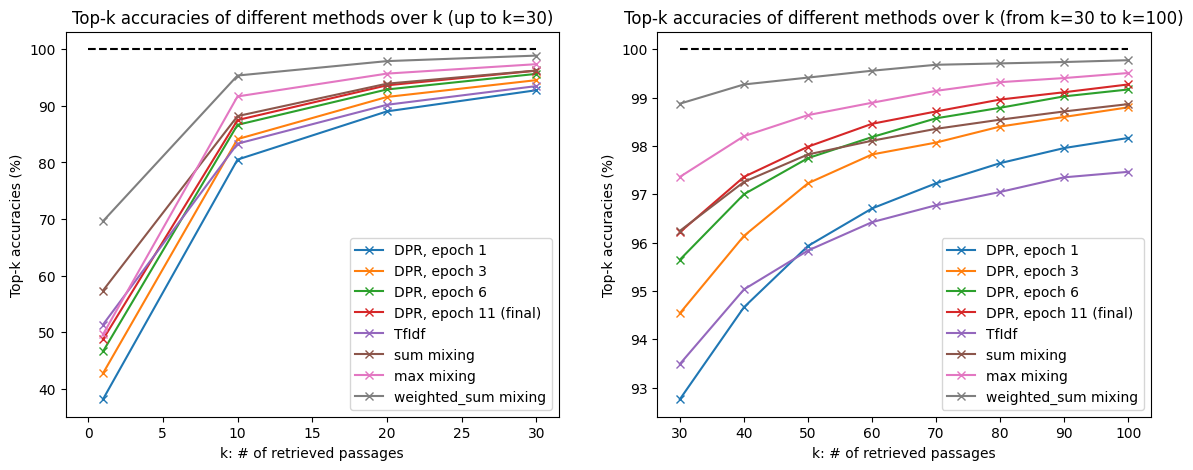

In [36]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))
ax1.set_xlabel("k: # of retrieved passages")
ax1.set_ylabel("Top-k accuracies (%)")
ax1.set_title("Top-k accuracies of different methods over k (up to k=30)")
ax2.set_title("Top-k accuracies of different methods over k (from k=30 to k=100)")
ax2.set_xlabel("k: # of retrieved passages")
ax2.set_ylabel("Top-k accuracies (%)")
for epoch in [1, 3, 6, 11]:
    ax1.plot([int(x) for x in count_top_k_per_epoch[epoch].keys()][:4], 
             [float(x)*100 for x in count_top_k_per_epoch[epoch].values()][:4],
            '-x', label=f"DPR, epoch {epoch}{' (final)' if epoch == 11 else ''}")
    ax2.plot([int(x) for x in count_top_k_per_epoch[epoch].keys()][3:],
             [float(x)*100 for x in count_top_k_per_epoch[epoch].values()][3:],
            '-x', label=f"DPR, epoch {epoch}{' (final)' if epoch == 11 else ''}")
ax1.plot([int(x) for x in count_top_k_tfidf.keys()][:4],
         [float(x)*100 for x in count_top_k_tfidf.values()][:4],
         '-x', label=f"TfIdf")
ax2.plot([int(x) for x in count_top_k_tfidf.keys()][3:],
         [float(x)*100 for x in count_top_k_tfidf.values()][3:],
         '-x', label=f"TfIdf")
for mix_type in MixingType:
    ax1.plot([int(x) for x in count_top_k_mixing[mix_type.name].keys()][:4],
             [float(x)*100 for x in count_top_k_mixing[mix_type.name].values()][:4],
             '-x', label=f"{mix_type.name.lower()} mixing")
    ax2.plot([int(x) for x in count_top_k_mixing[mix_type.name].keys()][3:],
             [float(x)*100 for x in count_top_k_mixing[mix_type.name].values()][3:],
             '-x', label=f"{mix_type.name.lower()} mixing")
ax1.hlines(100, 0, 30, linestyles='dashed', color='k')
ax2.hlines(100, 30, 100, linestyles='dashed', color='k')
ax1.legend()
ax2.legend()